In [58]:
import numpy as np
import matplotlib.pyplot as plt

input_file = "data_sets/julie_results.csv"

def open_data_file(input_file):
    with open(input_file, "r") as f:
        lines = f.readlines()
        data_lines = lines[1:]  # csv header
    return data_lines

data_lines = open_data_file(input_file)

# pokus aritmeticka chyba
def compute_arithmetic_error():    
    ar_diffs_all = []
    ar_expected_all = []

    ar_diffs_line = []
    ar_diffs_circle = []
    ar_diffs_square = []
    ar_diffs_star = []
    ar_diffs_polygon = []

    size_diff_all = []

    for i in range(len(data_lines)):
        data_lines[i] = data_lines[i].strip().split(",")
        data_lines[i][2] = int(data_lines[i][2])  
        data_lines[i][3] = int(data_lines[i][3])
        data_lines[i][4] = int(data_lines[i][4])

        sizeA = data_lines[i][2]
        sizeB = data_lines[i][3]
        sizeC = data_lines[i][4]

        size_diff = abs(sizeA - sizeC)

        ar_expected = (sizeA + sizeC) / 2
        diff = sizeB - ar_expected

        ar_expected_all.append(ar_expected)
        ar_diffs_all.append(diff)
        size_diff_all.append(size_diff)

        if data_lines[i][1] == "line":
            ar_diffs_line.append(diff)
        elif data_lines[i][1] == "circle":
            ar_diffs_circle.append(diff)
        elif data_lines[i][1] == "square":
            ar_diffs_square.append(diff)
        elif data_lines[i][1] == "star":
            ar_diffs_star.append(diff)
        elif data_lines[i][1] == "polygon":
            ar_diffs_polygon.append(diff)

        #print(f"SizeA: {sizeA}, SizeB: {sizeB}, SizeC: {sizeC}, Expected: {ar_expected}, Diff: {diff}, Size_diff: {size_diff}")

    return (size_diff_all, ar_expected_all, ar_diffs_all, ar_diffs_line, ar_diffs_circle, ar_diffs_square, ar_diffs_star, ar_diffs_polygon)

size_diff_all, ar_expected_all, ar_diffs_all, ar_diffs_line, ar_diffs_circle, ar_diffs_square, ar_diffs_star, ar_diffs_polygon = compute_arithmetic_error()


In [ ]:
plt.hist(ar_diffs_all, bins=np.arange(-15, 16, 1), edgecolor='black', color=np.random.rand(3))

plt.xlabel("Error (SizeB - Expected)")
plt.ylabel("Frequency")
plt.title("Arithmetic Error Distribution for all glyphs")
plt.grid(linestyle='--')

plt.show()


In [ ]:
glyph_diffs = {
    "line": ar_diffs_line,
    "square": ar_diffs_square,
    "circle": ar_diffs_circle,
    "star": ar_diffs_star,
    "polygon": ar_diffs_polygon
}

for glyph, diffs in glyph_diffs.items():
    plt.hist(diffs, bins=np.arange(-15, 16, 1), edgecolor='black', color=np.random.rand(3))
    plt.xlabel("Error (SizeB - Expected)")
    plt.ylabel("Frequency")
    plt.ylim(0, 5)
    plt.title(f"Error Distribution for {glyph.capitalize()}")
    plt.grid(linestyle='--')
    plt.show()

In [53]:
def compute_geometric_error():
    geo_diffs_all = []
    geo_diffs_line = []
    geo_diffs_circle = []
    geo_diffs_square = []
    geo_diffs_star = []
    geo_diffs_polygon = []

    for i in range(len(data_lines)):
        sizeA = data_lines[i][2]
        sizeB = data_lines[i][3]
        sizeC = data_lines[i][4]

        if sizeA == 0 or sizeC == 0:
            continue  # skip this entry to avoid division by zero

        geo_expected = (sizeA * sizeC) ** 0.5
        diff = sizeB - geo_expected

        geo_diffs_all.append(diff)

        if data_lines[i][1] == "line":
            geo_diffs_line.append(diff)
        elif data_lines[i][1] == "circle":
            geo_diffs_circle.append(diff)
        elif data_lines[i][1] == "square":
            geo_diffs_square.append(diff)
        elif data_lines[i][1] == "star":
            geo_diffs_star.append(diff)
        elif data_lines[i][1] == "polygon":
            geo_diffs_polygon.append(diff)

    return (geo_diffs_all, geo_diffs_line, geo_diffs_circle, geo_diffs_square, geo_diffs_star, geo_diffs_polygon)

geo_diffs_all, geo_diffs_line, geo_diffs_circle, geo_diffs_square, geo_diffs_star, geo_diffs_polygon = compute_geometric_error()

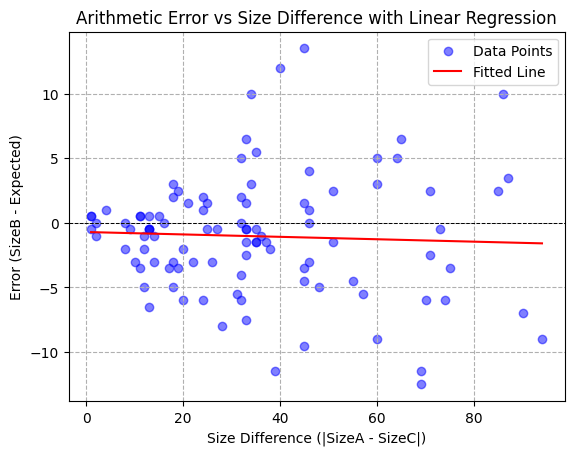

In [61]:
# linearni regrese pro aritmetickou chybu
# y = ax + b
def ar_linear_regression():
    coef = np.polyfit(size_diff_all, ar_diffs_all, 1)
    line = np.poly1d(coef)

    x_vals = np.linspace(min(size_diff_all), max(size_diff_all), 100)
    y_vals = line(x_vals)

    plt.scatter(size_diff_all, ar_diffs_all, color='blue', alpha=0.5, label='Data Points')
    plt.plot(x_vals, y_vals, color='red', label='Fitted Line')
    plt.xlabel('Size Difference (|SizeA - SizeC|)')
    plt.ylabel('Error (SizeB - Expected)')
    plt.title('Arithmetic Error vs Size Difference with Linear Regression')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

ar_linear_regression()

In [ ]:
# gamma correction
# P = S^gamma
# |S2^gamma - Sx^gamma| = |Sx^gamma - S1^gamma|

def normalize_sizes(sizes):
    normalized_sizes = []
    for size in sizes: 
        size = size / 100  # Normalize sizes to a range of 0 to 1
        normalized_sizes.append(size)
    return normalized_sizes

